In [1]:
# Import the libraries we will use

import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import svm

Using TensorFlow backend.


In [2]:
# Set ipython's max row display
pd.set_option('display.max_row', 10)

# Set iPython's max column width
pd.set_option('display.max_columns', 10)

In [3]:
# Read train.csv and show it to check it

dtypes = {'i': np.int32,
          'j': np.int32,
          't': np.int32,
          'price':np.float32,
          'advertised': np.bool}
dataset = pd.read_csv('train.csv', dtype=dtypes)
dataset

,i,j,t,price,advertised
0,4,7,0,2.137451,False
1,6,1,0,0.863341,False
2,8,6,0,0.799155,False
3,8,25,0,3.023894,False
4,9,6,0,0.799155,False
...,...,...,...,...,...
76497,1989,30,48,1.961365,False
76498,1990,15,48,0.924350,False
76499,1991,6,48,0.799155,False
76500,1994,30,48,1.961365,False


In [4]:
# If some i-j-t exists in dataset, that means that it was bought. Every other i-j-t not listed means that consumer i did not buy product j in week t
dataset['bought']=True
dataset

,i,j,t,price,advertised,bought
0,4,7,0,2.137451,False,True
1,6,1,0,0.863341,False,True
2,8,6,0,0.799155,False,True
3,8,25,0,3.023894,False,True
4,9,6,0,0.799155,False,True
...,...,...,...,...,...,...
76497,1989,30,48,1.961365,False,True
76498,1990,15,48,0.924350,False,True
76499,1991,6,48,0.799155,False,True
76500,1994,30,48,1.961365,False,True


In [5]:
# First we need to know the price and advertised value of each j in every t

product_states = dataset.drop(['i','bought'], axis='columns').drop_duplicates().sort_values(['t', 'j']).reset_index(drop=True)
product_states

# (I am assuming there is no incogruent information in the train set - ie: there are no rows with same j-t and different price or advertised value)

,j,t,price,advertised
0,0,0,1.717944,False
1,1,0,0.863341,False
2,2,0,3.366060,False
3,3,0,0.699985,False
4,4,0,2.012190,False
...,...,...,...,...
1950,35,48,1.153544,False
1951,36,48,1.513944,False
1952,37,48,2.941508,False
1953,38,48,1.537678,False


In [6]:
# Do some checkings 

num_consumers = len(dataset['i'].unique())
num_weeks = len(dataset['t'].unique())
num_products = len(dataset['j'].unique())

print('# of Consumers: {}'.format(num_consumers))
print('# of Weeks: {}'.format(num_weeks))
print('# of Products: {}'.format(num_products))


# of Consumers: 2000
# of Weeks: 49
# of Products: 40


In [7]:
# Now we need to know if there is some j-t that we do not have information about its price and advertised value

j = np.tile(np.arange(num_products), num_weeks)
t = np.repeat(np.arange(num_weeks), num_products)
aux = pd.DataFrame({'j':j,'t':t})
df_all = aux.merge(product_states.drop_duplicates(), on=['j','t'], 
                   how='left', indicator=True)
product_states_without_info = aux[df_all['_merge'] == 'left_only']
product_states_without_info

,j,t
396,36,9
659,19,16
1031,31,25
1346,26,33
1796,36,44


In [9]:
# That means that nobody bought those products j on those weeks t
# The problem is that we do not have the information about the price and advertised value of those combination, but we will assume they kept the price and advertised value of the previous week

for index, row in product_states_without_info.iterrows():
    info = product_states[(product_states['t']==row['t']-1)&(product_states['j']==row['j'])]
    product_states_without_info.loc[index, 'price']=info['price'].values
    product_states_without_info.loc[index, 'advertised']=info['advertised'].values.astype(bool) 
    
product_states_without_info


,j,t,price,advertised
396,36,9,1.513944,False
659,19,16,2.961606,False
1031,31,25,1.946499,False
1346,26,33,2.302829,False
1796,36,44,1.513944,False


In [10]:
product_states_full = pd.concat([product_states, product_states_without_info]).sort_values(['t', 'j']).reset_index(drop=True)
product_states_full

,j,t,price,advertised
0,0,0,1.717944,False
1,1,0,0.863341,False
2,2,0,3.366060,False
3,3,0,0.699985,False
4,4,0,2.012190,False
...,...,...,...,...
1955,35,48,1.153544,False
1956,36,48,1.513944,False
1957,37,48,2.941508,False
1958,38,48,1.537678,False


In [11]:
# We build the full dataset, which will have all the possible combinations of i-t-j-price-advertised-bought

t = np.repeat(np.arange(num_weeks), num_products*num_consumers)
j = np.tile(np.repeat(np.arange(num_products), num_consumers), num_weeks)
i = np.tile(np.arange(num_consumers), num_weeks*num_products)
clean_dataset = pd.DataFrame({'i':i,'j':j,'t':t})
full_dataset = clean_dataset.merge(product_states_full)
full_dataset = clean_dataset.merge(product_states_full).merge(dataset, how='left').fillna(False)
full_dataset.sort_values(['t','j','i'])
full_dataset

,i,j,t,price,advertised,bought
0,0,0,0,1.717944,False,False
1,1,0,0,1.717944,False,False
2,2,0,0,1.717944,False,False
3,3,0,0,1.717944,False,False
4,4,0,0,1.717944,False,False
...,...,...,...,...,...,...
3919995,1995,39,48,1.281862,False,False
3919996,1996,39,48,1.281862,False,False
3919997,1997,39,48,1.281862,False,False
3919998,1998,39,48,1.281862,False,False


In [12]:
# Feature Engineering:
#
#
# Now I need to build a model a train it. The input and output of the model will be:
# 
# x = (i, j, t, price, advertised)
# y = (bought)
#
# (I could skip the t input if we assume the the week number doesn't affect the decision to buy...
# ... but here I will consider it could affect, as maybe there is some time rate for the purchases)
#
# Data type of the inputs:
# i: It's categorical. Here I had two options: either tokenize so to use one-hot-encoding
#    (2000 dims) or use a 1 dim Input and the use an Embedding layer (X dims) to encode it.
#    I had tried both options, with similar results.
# j: It's categorical. Same as i input.
# t: It's ordinal, so I keep the int value (1 dim)
# price: It's ordinal, so I keep the float value (1 dim)
# advertised: It's boolean, so I keep the int value (1 dim)
#
# Note: We do not need to normalize ordinal inputs as we will use BatchNormalization in the model
#
# We will use a generator and fit_generator so we can tokenize de mini bathces on the fly,
# and we do not need to tokenize the whole dataset from the begining (it would require a lot of memory)

def myGenerator(dataset, batch_size, num_consumers, num_products, predict=0):
    
    while 1:
        
        for n in range(int(np.ceil(len(dataset)/batch_size))):
            
            # i = keras.utils.to_categorical(dataset['i'].values[n*batch_size:(n+1)*batch_size], num_consumers)
            # j = keras.utils.to_categorical(dataset['j'].values[n*batch_size:(n+1)*batch_size], num_products)
            i = dataset['i'].values[n*batch_size:(n+1)*batch_size]
            j = dataset['j'].values[n*batch_size:(n+1)*batch_size]            
            t = dataset['t'].values[n*batch_size:(n+1)*batch_size]
            p = dataset['price'].values[n*batch_size:(n+1)*batch_size]
            a = dataset['advertised'].values[n*batch_size:(n+1)*batch_size]
            
            if not predict:
                b = dataset['bought'].values[n*batch_size:(n+1)*batch_size]
                yield [i, j, t, p, a], b
            else:
                yield [i, j, t, p, a]
            

In [13]:
# Now we build the model

# Inputs

# i_input_layer = keras.layers.Input(shape=(num_consumers,))
# i_dense_layer = keras.layers.Dense(16, input_shape=(num_consumers,))(i_input_layer)
i_input_layer = keras.layers.Input(shape=(1,))
i_emb_layer = keras.layers.Embedding(num_consumers, 8, input_length=1)(i_input_layer)
i_flatten_layer = keras.layers.Flatten()(i_emb_layer)


# j_input_layer = keras.layers.Input(shape=(num_products,))
# j_dense_layer = keras.layers.Dense(16, input_shape=(num_products,))(j_input_layer)
j_input_layer = keras.layers.Input(shape=(1,))
j_emb_layer = keras.layers.Embedding(num_products, 8, input_length=1)(j_input_layer)
j_flatten_layer = keras.layers.Flatten()(j_emb_layer)


t_input_layer = keras.layers.Input(shape=(1,))

price_input_layer = keras.layers.Input(shape=(1,))

adv_input_layer = keras.layers.Input(shape=(1,))

# We merge the inputs

# merge = keras.layers.concatenate([i_dense_layer, j_dense_layer, t_input_layer, price_input_layer, adv_input_layer])
merge = keras.layers.concatenate([i_flatten_layer, j_flatten_layer, t_input_layer, price_input_layer, adv_input_layer])


# We create 2 Full Connected Layers, and a final Layer for Sigmoid

hidden1 = keras.layers.Dense(64, use_bias=False, activation='relu')(merge)
batch1 = keras.layers.BatchNormalization(axis=1)(hidden1)
drop1 = keras.layers.Dropout(0.8)(batch1)
hidden2 = keras.layers.Dense(128, use_bias=False, activation='relu')(drop1)
batch2 = keras.layers.BatchNormalization(axis=1)(hidden2)
drop2 = keras.layers.Dropout(0.8)(batch2)
output = keras.layers.Dense(1, activation='sigmoid')(drop2)
model = keras.models.Model(inputs=[i_input_layer, j_input_layer, t_input_layer, price_input_layer, adv_input_layer], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 8)         16000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embeddin

In [14]:
# Now we can train the model. But we have to take into account that the dataset is very imbalance
# It has a lot of combinations for Bought=0 outpus, compared to the Bought=1 outputs
# So first we need to put weights to the classes 

class_weight = {0: 1,
                1: (len(full_dataset)/len(dataset)-1)}

# We set the train parameters

batch_size = 4096
epochs = 5

validation_split = 0.1 # We will use validation set to see differences changing hyper-parameters
test_split = 0.1 # We will use test set to plot ROC and get AUC

val_th = int(len(full_dataset)-len(full_dataset)*(validation_split+test_split))
test_th = int(len(full_dataset)-len(full_dataset)*(test_split))

full_dataset = full_dataset.sample(frac=1)

train_set = full_dataset.iloc[:val_th]
validation_set = full_dataset.iloc[val_th:test_th]
test_set = full_dataset.iloc[test_th:]

train_steps_per_epoch = np.ceil(len(train_set) / batch_size) 
validation_steps = np.ceil(len(validation_set) / batch_size)
test_steps = np.ceil(len(test_set) / batch_size)
                          
train_data = myGenerator(train_set, batch_size, num_consumers, num_products)
validation_data = myGenerator(validation_set, batch_size, num_consumers, num_products)
test_data = myGenerator(test_set, batch_size, num_consumers, num_products)

In [15]:
# Now we train the model

history = model.fit_generator( train_data, steps_per_epoch=train_steps_per_epoch, validation_steps=validation_steps, class_weight=class_weight, epochs=epochs, shuffle=True, verbose=1, validation_data=validation_data)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
766/766 [==============================] - 60s 79ms/step - loss: 1.4179 - acc: 0.6285 - val_loss: 0.5410 - val_acc: 0.7545
Epoch 2/5
766/766 [==============================] - 47s 62ms/step - loss: 1.1592 - acc: 0.7157 - val_loss: 0.5266 - val_acc: 0.7325
Epoch 3/5
766/766 [==============================] - 47s 62ms/step - loss: 1.1347 - acc: 0.7130 - val_loss: 0.5137 - val_acc: 0.7184
Epoch 4/5
766/766 [==============================] - 60s 78ms/step - loss: 1.1234 - acc: 0.7057 - val_loss: 0.5049 - val_acc: 0.7280
Epoch 5/5
766/766 [==============================] - 49s 64ms/step - loss: 1.1144 - acc: 0.7006 - val_loss: 0.5045 - val_acc: 0.7239


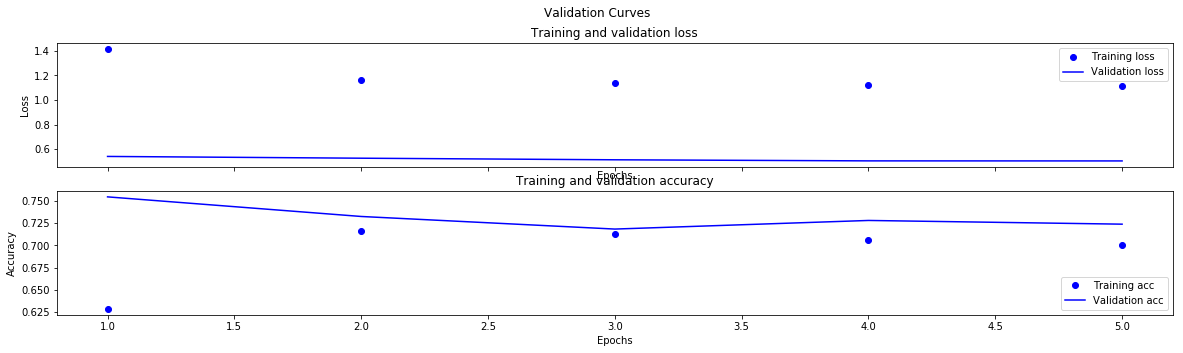

In [16]:
# We plot validation and curves

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Validation Curves')
f.set_size_inches((20, 5))

# VALIDATION LOSS curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
ax1.plot(epochs, loss, 'bo', label='Training loss')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

## VALIDATION ACCURACY curves
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(acc) + 1)
ax2.plot(epochs, acc, 'bo', label='Training acc')
ax2.plot(epochs, val_acc, 'b', label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [17]:
# We predict the test set

test_predictions = model.predict_generator( test_data, steps=test_steps, verbose=1)


96/96 [==============================] - 1s 10ms/step


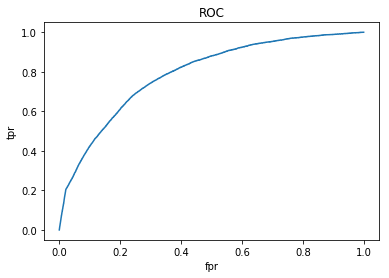

AUC-ROC score: 0.79


In [18]:
# We plot ROC and compute AUC

fpr, tpr, thresholds = metrics.roc_curve(y_true=test_set['bought'], y_score=test_predictions)
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC')
plt.show()
print('AUC-ROC score: {:.2f}'.format(metrics.auc(fpr, tpr)))

In [19]:
# Now we load the promotion information to compute the price and advertised for week 50

dtypes = {'j': np.int32,
          'discount': np.float32,
          'advertised': np.bool}
promotion = pd.read_csv('promotion_schedule.csv', dtype=dtypes)
promotion

,j,discount,advertised
0,0,0.0,False
1,1,0.0,False
2,2,0.0,False
3,3,0.0,False
4,4,0.0,False
...,...,...,...
34,35,0.0,False
35,36,0.0,False
36,37,0.0,False
37,38,0.0,False


In [20]:
# I found that information about j=20 is missing, so I just assume it:

promotion = promotion.append({'j': 20, 'discount': 0.0, 'advertised': False}, ignore_index=True).sort_values(['j']).reset_index(drop=True)
promotion

,j,discount,advertised
0,0,0.0,False
1,1,0.0,False
2,2,0.0,False
3,3,0.0,False
4,4,0.0,False
...,...,...,...
35,35,0.0,False
36,36,0.0,False
37,37,0.0,False
38,38,0.0,False


In [21]:
# We compute the product states (j-t-price-advertised) for weeek=49
product_states_t49 = product_states_full[product_states_full['t']==48].reset_index(drop=True)
product_states_t49['t'] = 49
product_states_t49['price'] *= (1-promotion['discount'])
product_states_t49['advertised'] = promotion['advertised']
product_states_t49

,j,t,price,advertised
0,0,49,1.717944,False
1,1,49,0.863341,False
2,2,49,3.366060,False
3,3,49,0.699985,False
4,4,49,2.012190,False
...,...,...,...,...
35,35,49,1.153544,False
36,36,49,1.513944,False
37,37,49,2.941508,False
38,38,49,1.537678,False


In [22]:
# We create the 80,000 possible i-j combinations for input of predictions

j = np.repeat(np.arange(num_products), num_consumers)
i = np.tile(np.arange(num_consumers), num_products)
aux_t49 = pd.DataFrame({'i':i,'j':j})
input_t49 = product_states_t49.merge(aux_t49)
input_t49

,j,t,price,advertised,i
0,0,49,1.717944,False,0
1,0,49,1.717944,False,1
2,0,49,1.717944,False,2
3,0,49,1.717944,False,3
4,0,49,1.717944,False,4
...,...,...,...,...,...
79995,39,49,1.281862,False,1995
79996,39,49,1.281862,False,1996
79997,39,49,1.281862,False,1997
79998,39,49,1.281862,False,1998


In [23]:
# We make the predictions with the neural netwrok that we trained

steps = np.ceil(len(input_t49) / batch_size)
                          
generator = myGenerator(input_t49, batch_size, num_consumers, num_products, predict=1)

predictions = model.predict_generator( generator, steps=steps, verbose=1)
predictions_df = pd.DataFrame({'i':i,'j':j, 'prediction':np.squeeze(predictions)})
predictions_df

20/20 [==============================] - 0s 9ms/step


,i,j,prediction
0,0,0,0.500811
1,1,0,0.554001
2,2,0,0.567267
3,3,0,0.581605
4,4,0,0.577150
...,...,...,...
79995,1995,39,0.629315
79996,1996,39,0.600774
79997,1997,39,0.633616
79998,1998,39,0.621503


In [24]:
# We save the predictions to a .csv file

predictions_df.to_csv('predictions.csv')